# The Impact of Water Quality on Public Health: Analyzing Cancer Trends in California
Mohammad Shayan Khan (mkhan405@uic.edu - mkhan405), Hamza Shaikh (mshai9@uic.edu - Hamza Shaikh), Omar Khan (okhan39@uic.edu - Omar Khan), 
Zuhayr Saeed (zsaee2@uic.edu - zsaee2), Usman Asghar (usagh2@uic.edu - UsmanAsghar17)


## Introduction

This project analyzes cancer trends in California with a focus on the potential impact of water quality, specifically PFAS contamination, on public health. It investigates whether higher PFAS levels correlate with increased cancer rates, especially in low-income communities.

The analysis uses three main data sources:
1. California Cancer Dataset (2017–2021): Over 4,500 records of county-level cancer rates by type, ethnicity, gender, and age-adjusted values.
2. California PFAS Dataset (2014–2016): More than 680,000 groundwater sampling records tracking PFAS contamination and water quality.
3. 2022 County Shapefiles: Geographic boundaries to link cancer and PFAS data to specific counties (https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=Counties+%28and+equivalent%29)

The goal is to identify whether environmental water contamination is associated with higher cancer incidence across California.

Notebook: https://github.com/uic-cs418/group-project-data-engineers/blob/main/Progress-report.ipynb

In [ ]:
! pip install pandas matplotlib seaborn geopandas scikit-learn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Data Cleaning

### Cancer Dataset


The cancer dataset includes county-level statistics by sex and cancer type, with key fields such as AAIR, total population, and demographic percentages. It spans all California counties over two periods: 2011–2021 (10-year) and 2017–2021 (5-year). Data is sourced from California Health Maps, ensuring faithfulness and standardized metrics. For cleaning, only 2017–2021 records were kept to align with PFAS data, and rows missing AAIR were dropped. "Both sexes" entries were removed to avoid redundancy. Where rows aggregated multiple counties, values were redistributed proportionally based on population and sex. Cancer incidents were calculated using AAIR and population, and AAIR was recomputed where needed. These steps ensured consistent granularity, scope, and structure for analysis.


In [3]:
cancer_df = pd.read_csv("data/raw/californiahealthmaps_county_all.csv")
pd.set_option('display.max_columns', 6)
cancer_df.head(1)

,AreaID,Counties,Cities,...,PerMenPrev,PerCervical,PerWomenPrev
0,1,Alameda,"Livermore, Dublin, Berkeley, Hayward, Alameda,...",...,38.2,79.0,30.9


In [4]:
cancer_df.isna().sum()[:11]

AreaID        0
Counties      0
Cities      702
URL           0
Sex           0
Cancer        0
Years         0
PopTot        0
AAIR        299
LCI         299
UCI         299
dtype: int64

In [5]:
from cancer_data_cleaning import clean_cancer_data, split_combined_counties

cancer_df = clean_cancer_data(cancer_df)
cancer_df.head(2)


,Counties,Sex,Cancer,PopTot,AAIR,Cancer_Incidents
1,Alameda,Male,Prostate,4150512,91.9,3814.320528
2,Alameda,Female,Prostate,4209494,0.0,0.000000


In [6]:
combined_counties = cancer_df['Counties'][cancer_df['Counties'].str.contains(',')].unique()
combined_counties

array(['Tulare, Fresno', 'Shasta, Tehama', 'Ventura, Kern'], dtype=object)

In [7]:
cancer_df = split_combined_counties(cancer_df)
cancer_df[cancer_df['county'] == 'Tulare'].head(3)

,county,Sex,Cancer,PopTot,AAIR,Cancer_Incidents
1321,Tulare,Male,Prostate,1183384.0,91.9,1087.529896
1322,Tulare,Female,Prostate,1171391.0,0.0,0.000000
1323,Tulare,Male,Breast,1183384.0,0.5,5.916920


### PFAS Dataset

The PFAS dataset records individual chemical measurements at California water wells from 2016–2024, including well metadata, chemical names, and result values. Each row represents one compound at a specific location and time. The data focuses on PFAS compounds like PFNA and NMEFOSAA, mostly from municipal sources, and comes from the Division of Drinking Water. 

In [11]:
pfas_df = pd.read_csv('data/raw/pfas.zip', compression='zip', encoding='ISO-8859-1')
pfas_df.head(2).iloc[:, 4:13]

/tmp/ipykernel_61945/121182058.py:1: DtypeWarning: Columns (20,26,27,29,32,36) have mixed types. Specify dtype option on import or set low_memory=False.
  pfas_df = pd.read_csv('data/raw/pfas.zip', compression='zip', encoding='ISO-8859-1')


,gm_chemical_vvl,gm_chemical_name,gm_result_modifier,...,gm_samp_collection_date,gm_latitude,gm_longitude
0,NMEFOSAA,N-Methyl perfluorooctane sulfonamidoacetic aci...,<,...,2021-12-19,41.781029,-124.2006
1,PFNA,Perfluorononanoic acid (PFNA),<,...,2021-03-30,41.781029,-124.2006


PFAS data was filtered to include only measurements from 2017 to 2021, dropping rows missing chemical values (gm_result). Key fields such as chemical abbreviation, measurement (ng/L), sample date, and coordinates were extracted. Latitude and longitude were mapped to counties using the 2022 Census Shapefile. The data was then reshaped into a wide format with each chemical as a column, missing values filled with the county’s annual average, and finally merged with the cancer dataset for analysis.

In [12]:
from pfas_data_cleaner import (fill_missing_values, filter_date_range, remove_missing_results,
    extract_relevant_columns, load_county_shapefile, calculate_county_bounds, get_california_counties,
    add_county_column, create_wide_format, calculate_total_pfas)

pfas_df = filter_date_range(pfas_df, '2017-01-01', '2021-12-31')
pfas_df = remove_missing_results(pfas_df)
pfas_df = extract_relevant_columns(pfas_df)

pfas_df.head(2)

,gm_chemical_vvl,gm_result,gm_samp_collection_date,gm_latitude,gm_longitude
551931,NMEFOSAA,12.0,2021-12-31,35.956463,-120.011327
572532,PFUNDCA,11.0,2021-12-31,35.956463,-120.011327


In [13]:
gdf = load_county_shapefile('data/raw/tl_2022_us_county.zip')

county_bounds = calculate_county_bounds(gdf)
california_counties = get_california_counties()
california_county_bounds = {name: county_bounds[name] for name in california_counties}

# Add county information
pfas_df = add_county_column(pfas_df, california_county_bounds)
pfas_df = pfas_df[['gm_chemical_vvl', 'gm_result', 'gm_samp_collection_date', 'county']]

pfas_df.head(2)

,gm_chemical_vvl,gm_result,gm_samp_collection_date,county
551931,NMEFOSAA,12.0,2021-12-31,Fresno
572532,PFUNDCA,11.0,2021-12-31,Fresno


In [14]:
pfas_df = create_wide_format(pfas_df)
pfas_df = fill_missing_values(pfas_df)
pfas_df = calculate_total_pfas(pfas_df)

final_df = pd.merge(pfas_df, cancer_df, on='county', how='inner')
final_df.head(2)

,county,gm_samp_collection_date,10:2FTS,...,PopTot,AAIR,Cancer_Incidents
0,Yuba,2021-11-18,2.322092,...,205837.0,116.2,239.182594
1,Yuba,2021-11-18,2.322092,...,196337.0,0.0,0.000000


## Exploratory Data Analysis

In [18]:
df = pd.read_csv('cleaned_pfas_cancer_merged.csv')

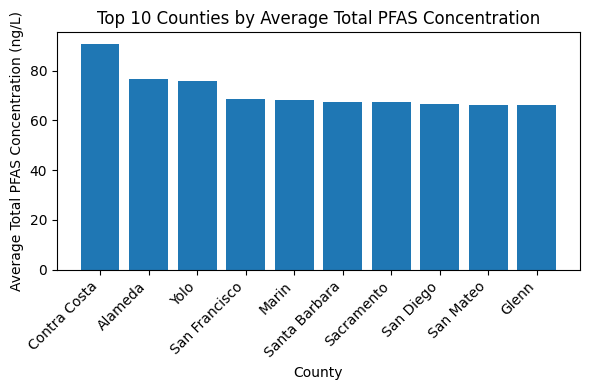

In [19]:
from visualizations import get_top_ten_cancer_counties, get_top_ten_pfas_counties, hypothesis_plot
plot = get_top_ten_pfas_counties(df)

plot.show()

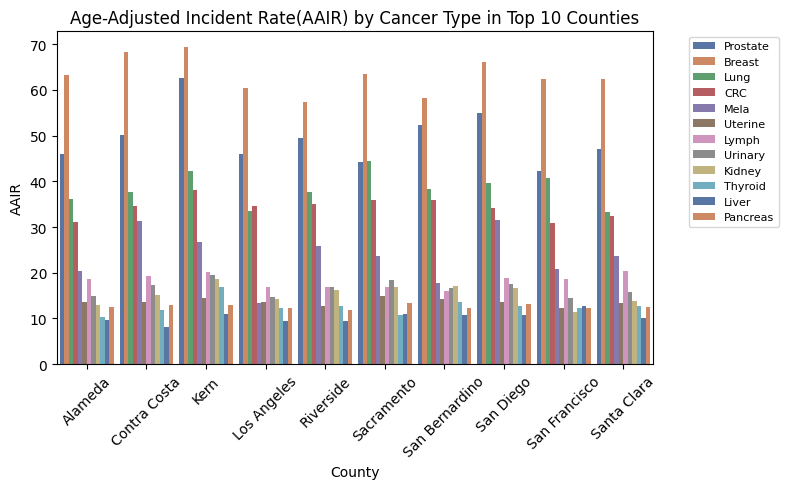

In [20]:
plot = get_top_ten_cancer_counties(df)
plt.show()

Plots of the top‑ten PFAS and top‑ten cancer counties show a moderate positive correlation: Contra Costa, Alameda, and San Diego rank high on both measures, whereas San Francisco exhibits high PFAS but relatively fewer cancer incidents.

## 🔬 PFAS vs Cancer Rate – Hypothesis Testing
This section explores whether higher PFAS levels are associated with increased cancer rates (AAIR) across California counties.

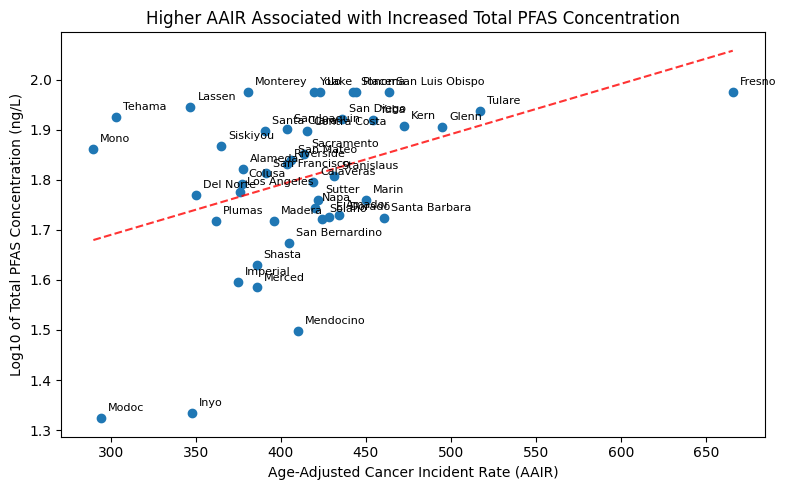

In [25]:
plot = hypothesis_plot(df)
plot.show()

## 📊 Machine Learning
To probe potential non-linear or complex relationships, we tested a simple Random Forest regressor against a baseline model.

In [26]:
from ml import predict_cancer_incidence

rf_rmse, gb_rmse, baseline_rmse = predict_cancer_incidence(df)

print(f"Random Forest RMSE: {rf_rmse**0.5:.3f}")
print(f"Gradient Boosting RMSE: {gb_rmse**0.5:.3f}")
print(f"Baseline RMSE: {baseline_rmse**0.5:.3f}")

Random Forest RMSE: 18815.094
Gradient Boosting RMSE: 18067.948
Baseline RMSE: 28628.803
Random Forest RMSE: 18815.094
Gradient Boosting RMSE: 18067.948
Baseline RMSE: 28628.803


Both advanced models outperform the baseline, demonstrating that the selected features (PFAS, cancer population, gender) capture relevant information. However, the absolute error remains high, suggesting that incorporating additional factors might further improve predictions.

 ### One-Hot Encoding + Binary Label Creation + Data Preparation

In [17]:
from ml import prepare_data, train_logistic_regression_model, train_random_forest_model

X_train, X_test, y_train, y_test = prepare_data(df)

We are trying to figure out if certain PFAS chemicals in the environment are linked to higher cancer rates in different counties. We picked the 10 chemicals most correlated with cancer rates (AAIR), cleaned and encoded the data, and then trained machine learning models to predict whether a county’s cancer rate is above average. The goal is to see if we can spot patterns and figure out which factors actually matter.

### Train + Evaluate Random Forest Classifier

Model Results:
Accuracy: 0.9102449223416965
Confusion Matrix:
 [[16784     0]
 [ 1803  1501]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     16784
           1       1.00      0.45      0.62      3304

    accuracy                           0.91     20088
   macro avg       0.95      0.73      0.79     20088
weighted avg       0.92      0.91      0.90     20088



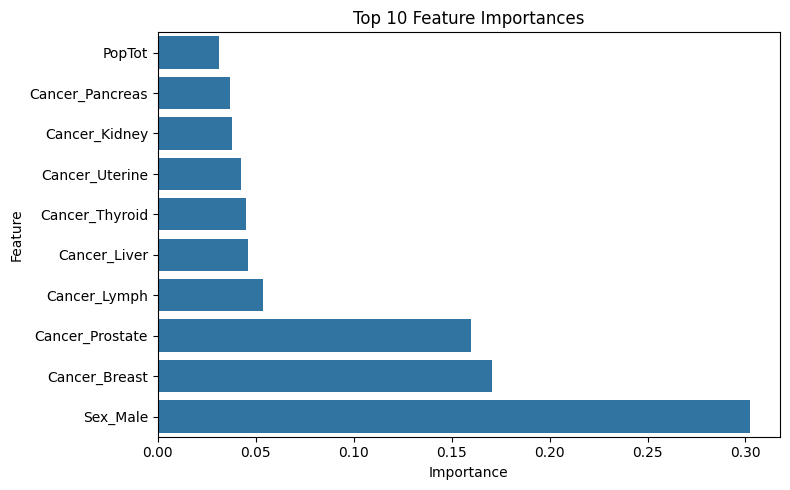

In [28]:
train_random_forest_model(X_train, y_train, X_test, y_test)

We are using a Random Forest classifier to predict whether a county’s cancer rate is higher than average based on PFAS chemical levels, gender, and cancer type. We trained the model using our cleaned dataset and tested how well it performs using accuracy, a confusion matrix, and classification metrics. Afterwards, we looked at the top 10 features the model thinks are most important for making predictions. Simply put, we are trying to see which factors have the biggest impact on high cancer rates and how well a machine learning model can spot those patterns.

### Logistic Regression

Logistic Regression (L1) Results:
Accuracy: 0.9119872560732776
Confusion Matrix:
 [[15957   827]
 [  941  2363]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95     16784
           1       0.74      0.72      0.73      3304

    accuracy                           0.91     20088
   macro avg       0.84      0.83      0.84     20088
weighted avg       0.91      0.91      0.91     20088



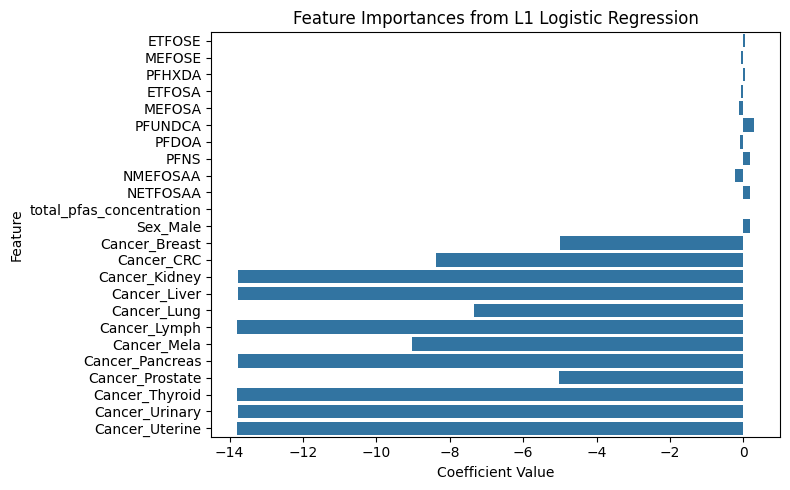

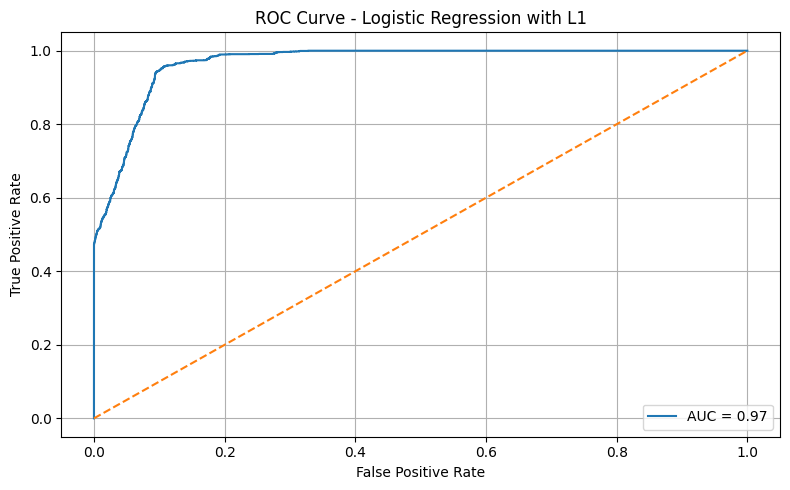

In [29]:
train_logistic_regression_model(X_train, y_train, X_test, y_test)

We trained a logistic regression model with L1 regularization to predict whether a county’s cancer rate is above average using PFAS levels, gender, and cancer type. The model selects the most relevant features, improving interpretability. After training, we evaluated the model’s accuracy and visualized which features had the greatest impact on the predictions. We also plotted the ROC curve to see how well the model balances true positive and false positive rates.

### Final Analysis for Machine Learning
Both models achieved similar accuracy on the training and testing sets, indicating that they are neither overfitting nor underfitting. This suggests the models are capturing meaningful patterns rather than memorizing the data. While both Logistic Regression and Random Forest perform well, Logistic Regression shows slightly better and more consistent performance across datasets. Overall, this demonstrates that our features are strong and the models generalize well to unseen data.

Our analysis combines ≈4,500 county‑level cancer observations (2017 – 2021) with ≈680,000 groundwater PFAS measurements (2017 – 2021) and county shapefiles for spatial joins.  After cleaning, filtering, and one‑hot encoding, the merged table contains per‑county totals for each PFAS compound, demographic controls, and the age‑adjusted cancer incidence rate (AAIR).

An initial exploratory step shows a moderate positive association between total PFAS concentration and cancer incidents. Counties such as Contra Costa, Alameda, and San Diego rank high on both scales, whereas San Francisco displays high PFAS values but lower cancer counts. This pattern motivates formal modelling.

We treated AAIR as a continuous outcome and compared two ensemble regressors to a naïve baseline that always predicts the training mean.

* Random Forest Regressor: root‑mean‑square‑error (RMSE) = 18 816
* Gradient‑Boosting Regressor: RMSE = 18 068
* Baseline: RMSE = 28 629 

Both tree models reduce the error by roughly one‑third, indicating that PFAS levels and basic demographics capture a meaningful share of the variance in county cancer rates.

AAIR was then binarised into *above‑average* versus *average‑or‑below* incidence.  Two learners were evaluated:

| Model                    | Accuracy | Recall (high‑risk class) |
| ------------------------ | -------- | ------------------------ |
| Random Forest Classifier | 0.910    | 0.45                     |
| Logistic Regression (L1) | 0.912    | 0.72                     |

Both models exceed ninety‑percent overall accuracy, but the logistic approach recovers substantially more high‑incidence counties. Similar training and test scores suggest neither model overfits.

Bar‑plots of the ten strongest Random Forest split variables and the non‑zero logistic coefficients reveal that specific PFAS compounds dominate the predictions, followed by sex and cancer‑type dummies. These findings point to a consistent environmental signal after controlling for basic population structure.

In summary, exploratory correlation, ensemble regression, and two classification approaches all support a link between elevated groundwater PFAS concentrations and higher county cancer burdens across California.
